In [ ]:
!pip install keras

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

/home/prithwiraj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """
Using TensorFlow backend.


In [127]:
''' Loading data '''
import pandas as pd
series = pd.read_csv('T1.csv',index_col="Date/Time")
series.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [128]:
# Hardcode all variables
window_size = 72
batch_size_exp = 1
epoch_exp = 1
neurons_exp = 50
predict_values_exp = (int)(len(series)*0.4)
lag_exp=24

In [129]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [130]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [131]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [132]:
# scale train and test data to [-1, 1]
'''
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
'''
def scale(data_norm):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(data_norm)
    # transform train
    data_norm = data_norm.reshape(data_norm.shape[0], data_norm.shape[1])
    data_scaled = scaler.transform(data_norm)
    return scaler, data_scaled
   

In [133]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [134]:
# fit an LSTM network to training data
from keras.layers import Activation, Dense, BatchNormalization, TimeDistributed
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons_exp, dropout = 0.1 ,batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(BatchNormalization())
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model

In [135]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [136]:
'''Drop all the features as we will not be having any in production'''
#del series['LV ActivePower (kW)']
del series['Wind Speed (m/s)']
del series['Wind Direction (°)']
del series['Theoretical_Power_Curve (KWh)']
series.head()

,LV ActivePower (kW)
Date/Time,
01 01 2018 00:00,380.047791
01 01 2018 00:10,453.769196
01 01 2018 00:20,306.376587
01 01 2018 00:30,419.645905
01 01 2018 00:40,380.650696


In [137]:
for i in range(0,10):
  series = series[:-1]
series.tail()

,LV ActivePower (kW)
Date/Time,
31 12 2018 21:30,1814.355957
31 12 2018 21:40,1992.348999
31 12 2018 21:50,2554.377930
31 12 2018 22:00,2681.270020
31 12 2018 22:10,3019.893066


In [138]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [139]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [140]:
# split data into train and test-sets
scaler,supervised_values = scale(supervised_values)
train_scaled, test_scaled = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]
print(len(train_scaled))
print(len(test_scaled))
#print(test_scaled)

30307
20212


In [141]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)

Epoch 1/1
30307/30307 [==============================] - 221s 7ms/step - loss: 0.0050


In [145]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
for i in range(len(test_scaled)-window_size):
    window_prediction_frame = test_scaled
    test_pred = list()
    for j in range(window_size):
        X, y = window_prediction_frame[i, 0:-1], window_prediction_frame[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
        '''# Start Debug prints
        print("X: %", X)
        print("yhat: %", yhat)
        # End Debug prints'''
        # Replacing value in test scaled with the predicted value.
        test_pred = [yhat] + test_pred 
        if len(test_pred) > lag_exp+1:
            test_pred = test_pred[:-1]
        if j+1<len(window_prediction_frame):
            if j+1 > lag_exp+1:
                window_prediction_frame[j+1] = test_pred
            else:
                window_prediction_frame[j+1] = np.concatenate((test_pred, window_prediction_frame[j+1, j+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train_scaled) + i + 1 + window_size]
    predictions.append(yhat)
    expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Hour=1, Predicted=2925.692289, Expected=3430.971924
Hour=2, Predicted=2934.369608, Expected=3106.830078
Hour=3, Predicted=2584.785787, Expected=3341.496094
Hour=4, Predicted=3222.016451, Expected=3274.018066
Hour=5, Predicted=3185.203070, Expected=3109.955078
Hour=6, Predicted=3111.288164, Expected=3524.468018
Hour=7, Predicted=2968.733402, Expected=3372.211914
Hour=8, Predicted=2965.032585, Expected=3429.122070
Hour=9, Predicted=2899.666097, Expected=2857.552979
Hour=10, Predicted=3294.610669, Expected=2622.128906
Hour=11, Predicted=3387.083346, Expected=2826.635010
Hour=12, Predicted=3261.100336, Expected=3435.820068
Hour=13, Predicted=3275.048941, Expected=3157.356934
Hour=14, Predicted=3247.635412, Expected=3413.687012
Hour=15, Predicted=3172.110718, Expected=3175.074951
Hour=16, Predicted=3453.570143, Expected=3156.155029
Hour=17, Predicted=3597.233796, Expected=3596.645996
Hour=18, Predicted=3456.802090, Expected=3575.975098
Hour=19, Predicted=3588.592041, Expected=3523.929932
Ho

Hour=156, Predicted=3044.227327, Expected=828.965881
Hour=157, Predicted=2975.054100, Expected=960.687073
Hour=158, Predicted=3053.158285, Expected=743.687012
Hour=159, Predicted=3191.157034, Expected=780.285522
Hour=160, Predicted=3171.953203, Expected=695.198120
Hour=161, Predicted=3203.347306, Expected=816.309326
Hour=162, Predicted=3612.232661, Expected=529.875793
Hour=163, Predicted=3486.242809, Expected=397.214813
Hour=164, Predicted=3802.810274, Expected=623.955078
Hour=165, Predicted=3476.022951, Expected=736.677185
Hour=166, Predicted=3570.446305, Expected=855.153687
Hour=167, Predicted=3435.526575, Expected=610.177612
Hour=168, Predicted=3606.713366, Expected=515.348389
Hour=169, Predicted=3520.236657, Expected=563.535278
Hour=170, Predicted=3292.566309, Expected=612.481201
Hour=171, Predicted=3110.883975, Expected=684.468018
Hour=172, Predicted=3167.599670, Expected=925.683289
Hour=173, Predicted=2941.329246, Expected=931.072021
Hour=174, Predicted=3015.289253, Expected=966.

Hour=310, Predicted=2334.294363, Expected=1024.053955
Hour=311, Predicted=2279.245849, Expected=907.543274
Hour=312, Predicted=2425.678858, Expected=1132.102051
Hour=313, Predicted=2183.918796, Expected=813.176575
Hour=314, Predicted=2012.443750, Expected=698.179016
Hour=315, Predicted=1842.973537, Expected=714.019226
Hour=316, Predicted=1912.315964, Expected=844.934875
Hour=317, Predicted=2212.783575, Expected=1129.899048
Hour=318, Predicted=2064.378331, Expected=974.877991
Hour=319, Predicted=1853.630468, Expected=1182.874023
Hour=320, Predicted=2318.339106, Expected=947.067688
Hour=321, Predicted=2415.789658, Expected=943.090271
Hour=322, Predicted=2293.162681, Expected=1281.936035
Hour=323, Predicted=2216.857418, Expected=1589.670044
Hour=324, Predicted=2076.326203, Expected=2310.370117
Hour=325, Predicted=2137.120170, Expected=1635.868042
Hour=326, Predicted=1837.138419, Expected=1726.114014
Hour=327, Predicted=1852.475958, Expected=1803.411011
Hour=328, Predicted=1877.764416, Exp

Hour=463, Predicted=2329.911880, Expected=880.535889
Hour=464, Predicted=2560.799774, Expected=912.838379
Hour=465, Predicted=2371.580526, Expected=824.851074
Hour=466, Predicted=2609.659869, Expected=907.256287
Hour=467, Predicted=2467.741633, Expected=1183.156982
Hour=468, Predicted=2518.686114, Expected=1316.319946
Hour=469, Predicted=2377.012086, Expected=1430.177002
Hour=470, Predicted=2527.431067, Expected=1085.659058
Hour=471, Predicted=2644.839426, Expected=848.288391
Hour=472, Predicted=2557.896852, Expected=1026.083008
Hour=473, Predicted=2748.278090, Expected=1018.216980
Hour=474, Predicted=2476.149792, Expected=907.767517
Hour=475, Predicted=2561.931989, Expected=1767.967041
Hour=476, Predicted=2324.556715, Expected=1897.472046
Hour=477, Predicted=2341.316172, Expected=2906.474121
Hour=478, Predicted=2162.825705, Expected=3052.706055
Hour=479, Predicted=1857.410446, Expected=3386.591064
Hour=480, Predicted=2407.411499, Expected=3265.558105
Hour=481, Predicted=1871.859608, E

Hour=617, Predicted=2799.056479, Expected=2410.934082
Hour=618, Predicted=2525.411399, Expected=2484.394043
Hour=619, Predicted=2798.704925, Expected=3047.881104
Hour=620, Predicted=2297.672611, Expected=3399.960938
Hour=621, Predicted=2348.954438, Expected=3411.769043
Hour=622, Predicted=2684.101256, Expected=3294.068115
Hour=623, Predicted=2687.614678, Expected=3462.093018
Hour=624, Predicted=2645.675673, Expected=3434.947021
Hour=625, Predicted=3187.692620, Expected=3143.222900
Hour=626, Predicted=2980.921658, Expected=3094.590088
Hour=627, Predicted=2458.431226, Expected=2935.907959
Hour=628, Predicted=2612.160949, Expected=2728.024902
Hour=629, Predicted=2411.769430, Expected=2592.031006
Hour=630, Predicted=2200.172081, Expected=2655.668945
Hour=631, Predicted=2333.334414, Expected=2892.705078
Hour=632, Predicted=2234.126051, Expected=2655.983887
Hour=633, Predicted=2226.373045, Expected=2468.389893
Hour=634, Predicted=2298.157715, Expected=2389.794922
Hour=635, Predicted=3020.907

Hour=770, Predicted=3443.876034, Expected=3491.019043
Hour=771, Predicted=3523.997672, Expected=3379.854004
Hour=772, Predicted=3654.753702, Expected=3583.712891
Hour=773, Predicted=3511.995160, Expected=3575.738037
Hour=774, Predicted=3635.112030, Expected=3541.504883
Hour=775, Predicted=3666.611761, Expected=3357.881104
Hour=776, Predicted=3452.761838, Expected=3470.568115
Hour=777, Predicted=3465.325160, Expected=3463.072021
Hour=778, Predicted=3323.242792, Expected=3569.115967
Hour=779, Predicted=3578.834510, Expected=3515.012939
Hour=780, Predicted=3440.660864, Expected=3467.454102
Hour=781, Predicted=3657.237543, Expected=3444.400879
Hour=782, Predicted=3568.266666, Expected=3595.055908
Hour=783, Predicted=3510.844951, Expected=3586.400879
Hour=784, Predicted=3540.696429, Expected=3603.318115
Hour=785, Predicted=3577.844080, Expected=3602.623047
Hour=786, Predicted=3454.805589, Expected=3586.951904
Hour=787, Predicted=3613.537845, Expected=3600.393066
Hour=788, Predicted=3596.900

Hour=922, Predicted=3482.321269, Expected=3511.399902
Hour=923, Predicted=3570.200926, Expected=3508.510010
Hour=924, Predicted=3541.473461, Expected=3498.920898
Hour=925, Predicted=3641.057152, Expected=3537.822021
Hour=926, Predicted=3630.484816, Expected=3470.141113
Hour=927, Predicted=3595.208774, Expected=3490.888916
Hour=928, Predicted=3620.045475, Expected=3577.456055
Hour=929, Predicted=3590.286030, Expected=3520.999023
Hour=930, Predicted=3581.093135, Expected=3441.349121
Hour=931, Predicted=3623.947379, Expected=3562.437012
Hour=932, Predicted=3535.499772, Expected=3544.018066
Hour=933, Predicted=3599.972681, Expected=3600.497070
Hour=934, Predicted=3494.449182, Expected=3582.808105
Hour=935, Predicted=3623.594896, Expected=3562.950928
Hour=936, Predicted=3595.805322, Expected=3470.638916
Hour=937, Predicted=3603.752467, Expected=3566.215088
Hour=938, Predicted=3609.093449, Expected=3573.355957
Hour=939, Predicted=3605.264171, Expected=3573.927002
Hour=940, Predicted=3597.206

Hour=1073, Predicted=3602.093273, Expected=3036.250977
Hour=1074, Predicted=3567.336912, Expected=2894.304932
Hour=1075, Predicted=3506.767916, Expected=2724.416016
Hour=1076, Predicted=3580.709960, Expected=2808.992920
Hour=1077, Predicted=3349.046621, Expected=2950.166016
Hour=1078, Predicted=3352.553559, Expected=3279.878906
Hour=1079, Predicted=3389.944259, Expected=3262.433105
Hour=1080, Predicted=3263.516165, Expected=3042.492920
Hour=1081, Predicted=3089.440006, Expected=2906.891113
Hour=1082, Predicted=2743.404434, Expected=2599.707031
Hour=1083, Predicted=2646.520913, Expected=2569.177002
Hour=1084, Predicted=2823.473981, Expected=2891.698975
Hour=1085, Predicted=2613.838744, Expected=2624.048096
Hour=1086, Predicted=2694.377139, Expected=2866.881104
Hour=1087, Predicted=2176.066785, Expected=2999.132080
Hour=1088, Predicted=1892.786119, Expected=3112.375000
Hour=1089, Predicted=2340.625191, Expected=3060.504883
Hour=1090, Predicted=2138.960506, Expected=3269.861084
Hour=1091,

Hour=1223, Predicted=2745.745687, Expected=2553.979004
Hour=1224, Predicted=2533.912543, Expected=2625.397949
Hour=1225, Predicted=2733.618146, Expected=2745.676025
Hour=1226, Predicted=2875.641701, Expected=3085.509033
Hour=1227, Predicted=2235.238770, Expected=3119.292969
Hour=1228, Predicted=2524.128076, Expected=3108.337891
Hour=1229, Predicted=3072.590664, Expected=2892.813965
Hour=1230, Predicted=2918.973024, Expected=3005.541016
Hour=1231, Predicted=2285.941981, Expected=2912.291016
Hour=1232, Predicted=2540.670216, Expected=2710.447021
Hour=1233, Predicted=2361.596154, Expected=2819.625977
Hour=1234, Predicted=1547.087851, Expected=2935.685059
Hour=1235, Predicted=1653.744381, Expected=2941.035889
Hour=1236, Predicted=3003.454819, Expected=2887.011963
Hour=1237, Predicted=2927.353615, Expected=2934.811035
Hour=1238, Predicted=2600.780153, Expected=2984.072998
Hour=1239, Predicted=2951.371045, Expected=3124.662109
Hour=1240, Predicted=2738.767278, Expected=3149.566895
Hour=1241,

Hour=1374, Predicted=246.528321, Expected=2320.627930
Hour=1375, Predicted=243.758229, Expected=2593.358887
Hour=1376, Predicted=188.729701, Expected=2848.847900
Hour=1377, Predicted=206.820541, Expected=3018.791992
Hour=1378, Predicted=288.061618, Expected=3093.220947
Hour=1379, Predicted=112.916580, Expected=2841.456055
Hour=1380, Predicted=171.613417, Expected=2805.729980
Hour=1381, Predicted=156.564708, Expected=2742.811035
Hour=1382, Predicted=175.604463, Expected=2681.038086
Hour=1383, Predicted=84.453650, Expected=2424.535889
Hour=1384, Predicted=-16.241757, Expected=2520.347900
Hour=1385, Predicted=18.248420, Expected=2613.345947
Hour=1386, Predicted=-9.963076, Expected=2564.741943
Hour=1387, Predicted=8.018895, Expected=2671.802002
Hour=1388, Predicted=-32.329819, Expected=2427.270996
Hour=1389, Predicted=-31.368883, Expected=2036.708008
Hour=1390, Predicted=36.395703, Expected=1758.876953
Hour=1391, Predicted=45.397614, Expected=1869.546021
Hour=1392, Predicted=-32.124788, Ex

Hour=1526, Predicted=515.281178, Expected=581.650208
Hour=1527, Predicted=387.304680, Expected=581.662170
Hour=1528, Predicted=249.613126, Expected=539.188782
Hour=1529, Predicted=362.432315, Expected=569.116516
Hour=1530, Predicted=418.808330, Expected=555.543823
Hour=1531, Predicted=275.585925, Expected=496.114685
Hour=1532, Predicted=407.926661, Expected=424.952698
Hour=1533, Predicted=327.708523, Expected=420.587585
Hour=1534, Predicted=262.755086, Expected=500.435303
Hour=1535, Predicted=100.988234, Expected=567.602295
Hour=1536, Predicted=390.983003, Expected=674.008301
Hour=1537, Predicted=218.962246, Expected=797.725830
Hour=1538, Predicted=122.084603, Expected=699.456726
Hour=1539, Predicted=314.098175, Expected=708.707825
Hour=1540, Predicted=331.781168, Expected=741.622681
Hour=1541, Predicted=786.523637, Expected=710.401611
Hour=1542, Predicted=1134.084145, Expected=815.352173
Hour=1543, Predicted=616.282152, Expected=910.775574
Hour=1544, Predicted=743.558527, Expected=107

Hour=1680, Predicted=454.244785, Expected=205.680206
Hour=1681, Predicted=671.853496, Expected=393.343811
Hour=1682, Predicted=1027.404710, Expected=768.454590
Hour=1683, Predicted=536.470337, Expected=865.369019
Hour=1684, Predicted=730.009032, Expected=705.669800
Hour=1685, Predicted=812.627331, Expected=592.840881
Hour=1686, Predicted=853.865018, Expected=404.275513
Hour=1687, Predicted=513.957021, Expected=399.442200
Hour=1688, Predicted=416.442941, Expected=694.765076
Hour=1689, Predicted=615.959631, Expected=875.099670
Hour=1690, Predicted=366.141096, Expected=961.087280
Hour=1691, Predicted=437.916341, Expected=1028.359009
Hour=1692, Predicted=594.587390, Expected=982.482117
Hour=1693, Predicted=852.819546, Expected=953.497314
Hour=1694, Predicted=694.607459, Expected=1145.182983
Hour=1695, Predicted=602.300015, Expected=1272.328003
Hour=1696, Predicted=491.854752, Expected=1265.724976
Hour=1697, Predicted=695.567073, Expected=1332.166016
Hour=1698, Predicted=546.861115, Expecte

Hour=1834, Predicted=317.789254, Expected=1038.681030
Hour=1835, Predicted=557.840502, Expected=866.237183
Hour=1836, Predicted=400.219203, Expected=619.380981
Hour=1837, Predicted=637.026970, Expected=696.792419
Hour=1838, Predicted=647.576484, Expected=639.047180
Hour=1839, Predicted=726.179127, Expected=550.461975
Hour=1840, Predicted=524.769699, Expected=484.175995
Hour=1841, Predicted=553.500611, Expected=652.692078
Hour=1842, Predicted=617.118738, Expected=485.773590
Hour=1843, Predicted=584.671287, Expected=539.344971
Hour=1844, Predicted=786.297120, Expected=662.835022
Hour=1845, Predicted=813.352543, Expected=600.221497
Hour=1846, Predicted=807.397831, Expected=399.098511
Hour=1847, Predicted=817.118991, Expected=319.082611
Hour=1848, Predicted=1103.099871, Expected=489.052704
Hour=1849, Predicted=1058.723121, Expected=508.113403
Hour=1850, Predicted=1019.009368, Expected=721.503723
Hour=1851, Predicted=1089.088952, Expected=827.842896
Hour=1852, Predicted=1107.273664, Expecte

Hour=1986, Predicted=2639.489444, Expected=3576.624023
Hour=1987, Predicted=3030.023256, Expected=3600.531982
Hour=1988, Predicted=3180.313216, Expected=3594.260010
Hour=1989, Predicted=2734.451309, Expected=3444.704102
Hour=1990, Predicted=2273.874572, Expected=2892.924072
Hour=1991, Predicted=1998.500220, Expected=3470.083008
Hour=1992, Predicted=1979.373566, Expected=3490.839111
Hour=1993, Predicted=1853.528774, Expected=3176.770020
Hour=1994, Predicted=2219.495939, Expected=3526.498047
Hour=1995, Predicted=2253.387553, Expected=3078.218018
Hour=1996, Predicted=2510.859712, Expected=2836.337891
Hour=1997, Predicted=3008.529254, Expected=3369.180908
Hour=1998, Predicted=3386.427095, Expected=3276.149902
Hour=1999, Predicted=3521.051907, Expected=3358.448975
Hour=2000, Predicted=3661.697684, Expected=2867.520996
Hour=2001, Predicted=3503.701409, Expected=3275.681885
Hour=2002, Predicted=3696.422434, Expected=3499.478027
Hour=2003, Predicted=3711.799132, Expected=3401.319092
Hour=2004,

KeyboardInterrupt: 

In [143]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations.mean()))*100))

Mean Absolute Percent Error:  28.36233503136047


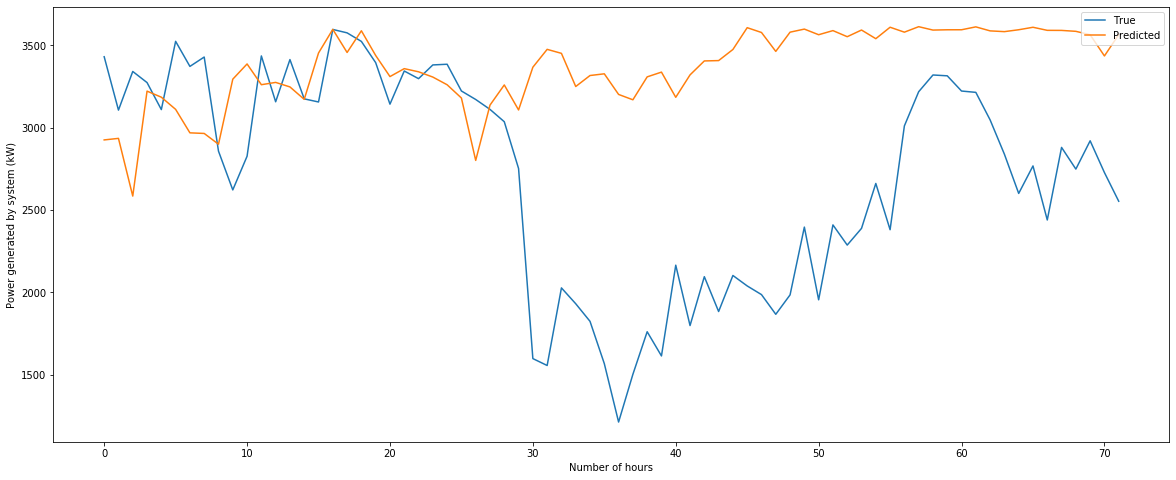

In [144]:
# line plot of observed vs predicted
fig = pyplot.figure(figsize=(20,8))
pyplot.plot(expectations[:500], label="True")
pyplot.plot(predictions[:500], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()